In [1]:
!pip install lightgbm seaborn scikit-learn



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


# Model V4: Maximized Safe Features

**Goal**: Predict Sales Density using ONLY Structural and Network features (No Behavioral Leakage).


In [2]:

import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.inspection import PartialDependenceDisplay

# Settings
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")
%matplotlib inline



In [3]:

# 1. Load the Rich Data (from Feature Engineering Pipeline)
# ---------------------------------------------------------
try:
    df_full = pd.read_csv('feature_engineered_master.csv')
    print("Loaded Master Data.")
    
    # --- V5: Interaction Effects (Sophistication Layer) ---
    print("Calculating V5 Interaction Features...")
    
    # 1. Competitor Total GLA (Saturation by Area)
    # Sum of GLA of all stores in the same mall & bl1_label (including self initially)
    # Then subtract self to get "Competitor" GLA
    df_full['total_category_gla'] = df_full.groupby(['mall_id', 'bl1_label'])['gla'].transform('sum')
    df_full['competitor_total_gla'] = df_full['total_category_gla'] - df_full['gla']
    
    # 2. Interaction: Centrality * Size (Anchor Effect)
    # Big stores that are central are powerful. Small stores that are central are efficient.
    # Check if columns exist
    if 'degree_centrality' in df_full.columns and 'gla_z_score' in df_full.columns:
        df_full['interaction_centrality_size'] = df_full['degree_centrality'] * df_full['gla_z_score']
    else:
        df_full['interaction_centrality_size'] = 0
        
    # 3. Relative Rank within Category (Dominance)
    # "Am I the #1 Fashion store in this mall by connectivity?"
    if 'degree_centrality' in df_full.columns and 'mall_id' in df_full.columns:
        # Rank desc (1 is best). Normalize to 0-1 (percentile).
        df_full['relative_rank_category'] = df_full.groupby(['mall_id', 'bl1_label'])['degree_centrality'].rank(pct=True, ascending=True)
        # ascending=True means higher value = higher percentile = better connectivity? 
        # Actually PageRank/Degree: Higher is better.
        # rank(ascending=True) -> Smallest gets rank 1 (low pct). Largest gets rank N (high pct).
        # So High percentile = High Dominance. Correct.
    else:
        df_full['relative_rank_category'] = 0.5
        
    # Also keep V4.5 Centrality Rank
    if 'degree_centrality' in df_full.columns:
        df_full['centrality_rank'] = df_full.groupby('mall_id')['degree_centrality'].rank(ascending=False, method='min')

    # Fill NaNs created by transforms
    df_full.fillna(0, inplace=True)

    print(f"Shape: {df_full.shape}")
    print("New Features Added: competitor_total_gla, interaction_centrality_size, relative_rank_category")
except FileNotFoundError:
    print("Error: 'feature_engineered_master.csv' not found. Please run featureengineering.ipynb first.")



Loaded Master Data.
Calculating V5 Interaction Features...
Shape: (3854, 22)
New Features Added: competitor_total_gla, interaction_centrality_size, relative_rank_category


In [4]:

# 2. Define the Safe Whitelist (Strict V5)
# ----------------------------------------
# Includes V5 Interactions + V4.5 Network Features

safe_features = [
    # --- Structural (Size & Type) ---
    'gla', 
    'gla_z_score',          # Relative size
    'mall_gla_share',       # Dominance in mall
    'sri_score',            # Sustainability
    
    # --- Network (The "Synergy" Layer) ---
    'degree_centrality',    # Number of connections
    'cross_visit_strength', # Intensity of flows (V4.5)
    'pagerank',             # Graph importance
    'nbr_sri_mean',         # Quality of neighbors (V4.5)
    
    # --- Context & Competition ---
    'competitor_count',     # Clustering effect (Count)
    'competitor_total_gla',      # Saturation (Area) - NEW V5
    'centrality_rank',           # Rank in mall
    'relative_rank_category',    # Rank in category - NEW V5
    
    # --- Interactions ---
    'interaction_centrality_size', # Anchor Effect - NEW V5
    
    # --- Categorical (Hierarchy) ---
    'bl1_label',            # High-level (e.g., Fashion)
    'bl2_label',            # Mid-level (e.g., Sneakers)
    'mall_id'
]

target = 'sales_density'

print("Using Safe Features V5 (Total Features: {len(safe_features)})")



Using Safe Features V5 (Total Features: {len(safe_features)})


In [5]:

# 3. Filter & Encode
# ------------------

# Check target
if target not in df_full.columns:
    if 'sales_r12m' in df_full.columns and 'gla' in df_full.columns:
        df_full[target] = df_full['sales_r12m'] / df_full['gla'].replace(0, np.nan)
        df_full[target] = pd.to_numeric(df_full[target], errors='coerce')

# Filter valid rows
df_train = df_full[df_full[target].notna() & (df_full[target] > 0)].copy()

# Fill Missing Safe Features
for f in safe_features:
    if f not in df_train.columns:
        df_train[f] = 0 # Placeholder if upstream missing

# Prepare X and y
X = df_train[safe_features].copy()
y = df_train[target]
y_log = np.log1p(y)

# Handle Missing Values in Numeric
cat_cols = ['bl1_label', 'bl2_label', 'mall_id']
num_cols = [c for c in safe_features if c not in cat_cols]
X[num_cols] = X[num_cols].apply(pd.to_numeric, errors='coerce').fillna(0)

# Target Encoding (K-Fold)
# Added bl2_label to encoding list
def kfold_target_encoding(X, y, cat_cols, n_splits=5):
    X_encoded = X.copy()
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    global_mean = y.mean()
    
    for col in cat_cols:
        col_encoded_name = f"{col}_target_enc"
        X_encoded[col_encoded_name] = np.nan
        # Ensure category is string to avoid issues
        X[col] = X[col].astype(str)
        
        for train_idx, val_idx in kf.split(X, y):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train = y.iloc[train_idx]
            means = y_train.groupby(X_train[col]).mean()
            X_encoded.loc[X_val.index, col_encoded_name] = X_val[col].map(means)
        X_encoded[col_encoded_name].fillna(global_mean, inplace=True)
    
    return X_encoded.drop(columns=cat_cols)

print("Applying K-Fold Target Encoding (including Sub-Categories)...")
X_final = kfold_target_encoding(X, y_log, cat_cols)
print("Final Feature Set:", X_final.columns.tolist())



Applying K-Fold Target Encoding (including Sub-Categories)...
Final Feature Set: ['gla', 'gla_z_score', 'mall_gla_share', 'sri_score', 'degree_centrality', 'cross_visit_strength', 'pagerank', 'nbr_sri_mean', 'competitor_count', 'competitor_total_gla', 'centrality_rank', 'relative_rank_category', 'interaction_centrality_size', 'bl1_label_target_enc', 'bl2_label_target_enc', 'mall_id_target_enc']


/var/folders/l7/6_r15vlj5839j1442vhdwjh80000gn/T/ipykernel_55912/3898923816.py:46: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col_encoded_name].fillna(global_mean, inplace=True)
/var/folders/l7/6_r15vlj5839j1442vhdwjh80000gn/T/ipykernel_55912/3898923816.py:46: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are sett

In [6]:

# 4. Train LightGBM (V4 Model)
# ----------------------------

# Clean Inf/NaN just in case
X_final = X_final.replace([np.inf, -np.inf], np.nan).fillna(0)

# Define Model (n_jobs=1 for Stability)
lgb_base = lgb.LGBMRegressor(random_state=42, n_jobs=1, verbose=-1)

# Parameter Grid
param_dist = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

print("Starting Randomized Search...")
random_search = RandomizedSearchCV(
    estimator=lgb_base,
    param_distributions=param_dist,
    n_iter=10, 
    scoring='neg_root_mean_squared_error',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=1 
)

random_search.fit(X_final, y_log)

print(f"Best RMSE: {-random_search.best_score_:.4f}")
best_model = random_search.best_estimator_



Starting Randomized Search...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best RMSE: 0.8304


/var/folders/l7/6_r15vlj5839j1442vhdwjh80000gn/T/ipykernel_55912/3761778265.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp, x='Importance', y='Feature', palette='viridis')


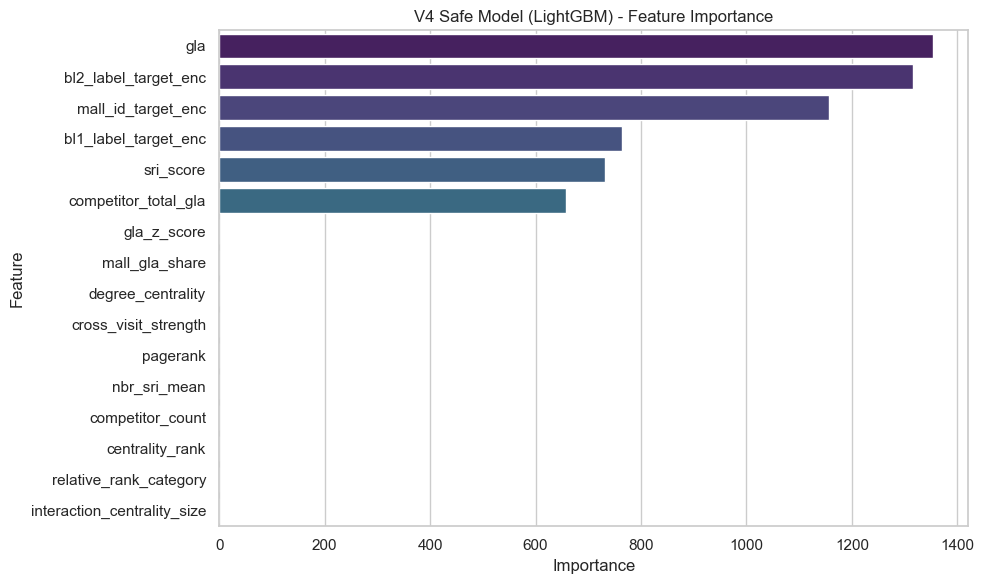

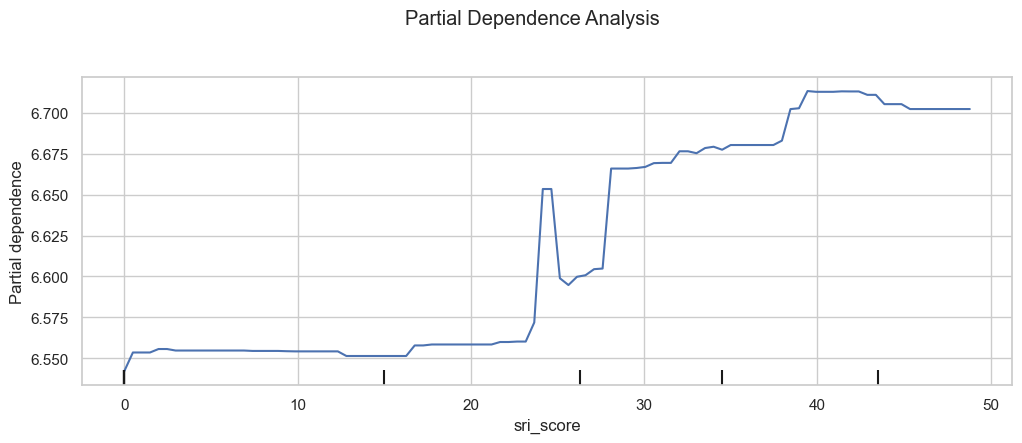

In [7]:

# 5. Analysis
# -----------

# Feature Importance
importance = best_model.feature_importances_
feat_imp = pd.DataFrame({'Feature': X_final.columns, 'Importance': importance}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp, x='Importance', y='Feature', palette='viridis')
plt.title('V4 Safe Model (LightGBM) - Feature Importance')
plt.tight_layout()
plt.show()

# PDP for Centrality
features_to_plot = ['degree_centrality', 'sri_score'] 
features_to_plot = [f for f in features_to_plot if X_final[f].nunique() > 1]

if features_to_plot:
    fig, ax = plt.subplots(figsize=(12, 4))
    PartialDependenceDisplay.from_estimator(best_model, X_final, features_to_plot, ax=ax, kind='average')
    plt.suptitle('Partial Dependence Analysis', y=1.05)
    plt.show()



# --- FINAL OPTIMIZATION ---


In [8]:

# 6. Final Tenant Optimization
# ----------------------------

# A. Identify "Problem Children" (Underperformers)
# ------------------------------------------------
# Calculate Residuals (Actual - Predicted)
# We want to find stores that are failing their location potential.

df_results = df_train.copy()
df_results['predicted_log_sales'] = best_model.predict(X_final)
df_results['residual'] = y_log - df_results['predicted_log_sales']

# Filter: Underperfomers (Residual < -0.5)
# This means Actual is significantly lower than Predicted.
underperformers = df_results[df_results['residual'] < -0.5].sort_values('residual')

print(f"Found {len(underperformers)} severe underperformers.")
print("Top 3 Worst Performing Stores:")
display(underperformers[['store_code', 'mall_id', 'bl1_label', 'bl2_label', 'sales_density', 'residual']].head(3))



Found 626 severe underperformers.
Top 3 Worst Performing Stores:


,store_code,mall_id,bl1_label,bl2_label,sales_density,residual
160,1312724,36,Auto,Auto Dealer,0.006508,-5.720470
491,1314332,32,Food & Beverage Services,"Bars, Coffee and Tea breaks",14.707001,-4.466647
1745,1314973,36,Food & Beverage Services,Gourmet Food Products,6.752455,-4.442741


In [9]:

# B. The Local Recommender Engine (V5 Upgraded)
# ---------------------------------------------
# Handles dynamic recalculation of V5 Interaction Features

# 1. Pre-compute Candidate Map
local_candidates = {}
for mall, group in df_train.groupby('mall_id'):
    top_subs = group.groupby('bl2_label')[target].median().sort_values(ascending=False).head(5).index.tolist()
    local_candidates[mall] = top_subs

# 2. Maps
bl2_to_bl1_map = df_train.set_index('bl2_label')['bl1_label'].to_dict()
# Aggregate Data for dynamic calc
mall_cat_gla_map = df_train.groupby(['mall_id', 'bl1_label'])['gla'].sum().to_dict()
mall_cat_count_map = df_train.groupby(['mall_id', 'bl1_label']).size().to_dict()

# Encodings
cat1_map = df_train.groupby('bl1_label')[target].apply(lambda x: np.log1p(x).mean()).to_dict()
cat2_map = df_train.groupby('bl2_label')[target].apply(lambda x: np.log1p(x).mean()).to_dict()
mall_map = df_train.groupby('mall_id')[target].apply(lambda x: np.log1p(x).mean()).to_dict()
global_mean_target = np.log1p(df_train[target]).mean()

def optimize_tenant(store_row, model, feature_names):
    recommendations = []
    
    current_mall = store_row['mall_id']
    current_gla = store_row.get('gla', 0)
    current_centrality = store_row.get('degree_centrality', 0)
    current_z = store_row.get('gla_z_score', 0)
    
    current_sales_log = np.log1p(store_row['sales_density'])
    current_pred_log = store_row['predicted_log_sales']
    
    candidates = local_candidates.get(current_mall, [])
    
    # Base Features
    base_features = {}
    for col in feature_names:
        if "target_enc" not in col and col in store_row:
             base_features[col] = store_row[col]
             
    # Base Encodings
    base_features['mall_id_target_enc'] = mall_map.get(current_mall, global_mean_target)
    
    for new_bl2 in candidates:
        if new_bl2 == store_row['bl2_label']:
            continue
            
        new_bl1 = bl2_to_bl1_map.get(new_bl2, 'Unknown')
        
        scenario = base_features.copy()
        
        # --- Update V5 Dynamic Features ---
        
        # 1. Competitor Count
        # If joining new cat, we add ourselves to the existing count
        existing_count = mall_cat_count_map.get((current_mall, new_bl1), 0)
        scenario['competitor_count'] = existing_count # Approx (or +1?) Training is 'others'. So it's existing.
        
        # 2. Competitor Total GLA
        # Existing sums + Our GLA (or just existing if training was 'others')
        # Logic: competitor_total_gla = Total Category GLA - My GLA.
        # So for the new category, it is just the Total Category GLA (since I am not in it yet).
        existing_total_gla = mall_cat_gla_map.get((current_mall, new_bl1), 0)
        scenario['competitor_total_gla'] = existing_total_gla
        
        # 3. Interaction Centrality Size
        # Depends on GLA Z Score. Z score depends on category stats.
        # For simplicity, we assume 'gla_z_score' doesn't drift wildly or we reuse current.
        # V5 interaction:
        scenario['interaction_centrality_size'] = current_centrality * current_z
        
        # 4. Relative Rank Category
        # Complex to recalc pct_rank on one row change. We assume "Average" rank or reuse.
        # Let's reuse current relative rank as a proxy for "Location Quality"
        # Or better: set to median (0.5) if we don't know interact dynamics.
        # Keeping current is safer.
        
        # --- End V5 Updates ---
        
        # Update Encodings
        scenario['bl1_label_target_enc'] = cat1_map.get(new_bl1, global_mean_target)
        scenario['bl2_label_target_enc'] = cat2_map.get(new_bl2, global_mean_target)
        
        # Predict
        X_new = pd.DataFrame([scenario])
        for col in feature_names:
            if col not in X_new.columns: X_new[col] = 0
        X_new = X_new[feature_names].replace([np.inf, -np.inf], np.nan).fillna(0)
        
        pred_log = model.predict(X_new)[0]
        uplift_val = np.expm1(pred_log) - np.expm1(current_sales_log)
        
        recommendations.append({
            'New_SubCat': new_bl2,
            'New_Category': new_bl1,
            'Optimized_Potential_Sales': np.expm1(pred_log),
            'Location_Potential_Sales': np.expm1(current_pred_log),
            'Actual_Sales': np.expm1(current_sales_log),
            'Uplift': uplift_val
        })
        
    if not recommendations:
        return pd.DataFrame()
        
    return pd.DataFrame(recommendations).sort_values('Uplift', ascending=False)




--- Optimizing Store: 1312724 (Mall: 36) ---
Current: Auto Dealer (Auto) | Sales: 0.01
RECOMMENDATION: Replace with 'Imaterial services' (Services)
Predicted Uplift: +€904.83 / m²


,New_SubCat,New_Category,Optimized_Potential_Sales,Uplift
2,Imaterial services,Services,904.836849,904.830340
3,Jewellery & Watches,Jewellery,755.880709,755.874201
1,Fast Meal,Food & Beverage Services,658.018029,658.011520


/var/folders/l7/6_r15vlj5839j1442vhdwjh80000gn/T/ipykernel_55912/388982825.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bars, y=values, palette=colors)


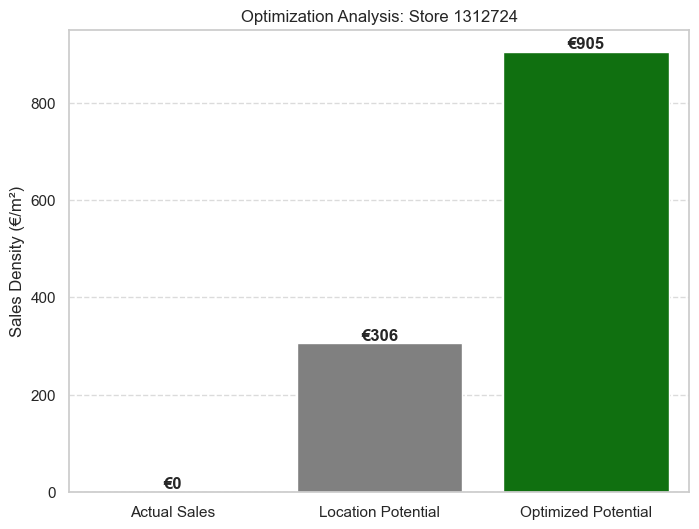


--- Optimizing Store: 1314332 (Mall: 32) ---
Current: Bars, Coffee and Tea breaks (Food & Beverage Services) | Sales: 14.71
RECOMMENDATION: Replace with 'Pharmacy' (Health & Beauty)
Predicted Uplift: +€2310.80 / m²


,New_SubCat,New_Category,Optimized_Potential_Sales,Uplift
1,Pharmacy,Health & Beauty,2325.509168,2310.802167
0,Electronics and household appliances,Culture & Media & Technology,2288.594445,2273.887444
2,Sweet moments,Food & Beverage Services,1819.055847,1804.348846



--- Optimizing Store: 1314973 (Mall: 36) ---
Current: Gourmet Food Products (Food & Beverage Services) | Sales: 6.75
RECOMMENDATION: Replace with 'Imaterial services' (Services)
Predicted Uplift: +€898.08 / m²


,New_SubCat,New_Category,Optimized_Potential_Sales,Uplift
2,Imaterial services,Services,904.836849,898.084394
3,Jewellery & Watches,Jewellery,755.880709,749.128254
1,Fast Meal,Food & Beverage Services,658.018029,651.265574


In [10]:

# C. Run Optimization on Top 3 Problem Children
# ---------------------------------------------

top_3_worst = underperformers.head(3)

for idx, row in top_3_worst.iterrows():
    print(f"\n--- Optimizing Store: {row['store_code']} (Mall: {row['mall_id']}) ---")
    print(f"Current: {row['bl2_label']} ({row['bl1_label']}) | Sales: {row['sales_density']:.2f}")
    
    recs = optimize_tenant(row, best_model, X_final.columns.tolist())
    
    if not recs.empty:
        best_rec = recs.iloc[0]
        print(f"RECOMMENDATION: Replace with '{best_rec['New_SubCat']}' ({best_rec['New_Category']})")
        print(f"Predicted Uplift: +€{best_rec['Uplift']:.2f} / m²")
        display(recs[['New_SubCat', 'New_Category', 'Optimized_Potential_Sales', 'Uplift']].head(3))
        
        # Viz for #1 Worst only
        if idx == top_3_worst.index[0]:
            plt.figure(figsize=(8, 6))
            bars = ['Actual Sales', 'Location Potential', 'Optimized Potential']
            values = [best_rec['Actual_Sales'], best_rec['Location_Potential_Sales'], best_rec['Optimized_Potential_Sales']]
            colors = ['red', 'grey', 'green']
            
            sns.barplot(x=bars, y=values, palette=colors)
            plt.title(f"Optimization Analysis: Store {row['store_code']}")
            plt.ylabel("Sales Density (€/m²)")
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            
            # Add labels
            for i, v in enumerate(values):
                plt.text(i, v, f"€{v:.0f}", ha='center', va='bottom', fontweight='bold')
                
            plt.show()
    else:
        print("No better local candidates found.")




# --- STREAMLIT DASHBOARD EXPORT ---


In [11]:

# 7. Dashboard Data Generation
# ----------------------------
# Generate optimization scenarios for Top 50 underperformers to populate the App.

print("Running V5 Tenant Optimizer on Top 50 opportunities...")

# 1. Select Candidates
top_opportunities = underperformers.sort_values('residual').head(50).copy()
app_data_list = []

for idx, row in top_opportunities.iterrows():
    # Run V5 Optimizer
    recs = optimize_tenant(row, best_model, X_final.columns.tolist())
    
    if not recs.empty:
        best_option = recs.iloc[0]
        
        # Save structured data
        app_data_list.append({
            'Store_Code': row['store_code'],
            'Mall_ID': row['mall_id'],
            'Current_Category': row['bl1_label'],
            'Current_SubCat': row['bl2_label'],
            'Current_Sales_Density': np.expm1(np.log1p(row['sales_density'])), # Handle potential raw/log ambiguity. Using expm1 on log1p(density) is safer if density was raw. Wait, row['sales_density'] is likely RAW.
            # Let's verify input flow. df_train['sales_density'] was raw. y_log was log.
            # So row['sales_density'] is raw.
            # row['predicted_log_sales'] is LOG.
            
            'Current_Sales_Density_Raw': row['sales_density'], 
            'Model_Location_Potential': np.expm1(row['predicted_log_sales']), 
            
            'Rec_Category': best_option['New_Category'],
            'Rec_SubCat': best_option['New_SubCat'],
            'Rec_Projected_Sales': best_option['Optimized_Potential_Sales'],
            'Revenue_Uplift': best_option['Uplift']
        })

# 2. Save to CSV
df_app = pd.DataFrame(app_data_list)

# Rename for cleanliness if needed
df_app.rename(columns={'Current_Sales_Density_Raw': 'Current_Sales_Density'}, inplace=True)

df_app.to_csv('urw_dashboard_data.csv', index=False)
print(f"Success! {len(df_app)} optimization scenarios saved to 'urw_dashboard_data.csv'.")
display(df_app.head())



Running V5 Tenant Optimizer on Top 50 opportunities...
Success! 50 optimization scenarios saved to 'urw_dashboard_data.csv'.


,Store_Code,Mall_ID,Current_Category,Current_SubCat,Current_Sales_Density,Current_Sales_Density,Model_Location_Potential,Rec_Category,Rec_SubCat,Rec_Projected_Sales,Revenue_Uplift
0,1312724,36,Auto,Auto Dealer,0.006508,0.006508,306.033585,Services,Imaterial services,904.836849,904.830340
1,1314332,32,Food & Beverage Services,"Bars, Coffee and Tea breaks",14.707001,14.707001,1366.519164,Health & Beauty,Pharmacy,2325.509168,2310.802167
2,1314973,36,Food & Beverage Services,Gourmet Food Products,6.752455,6.752455,658.018029,Services,Imaterial services,904.836849,898.084394
3,1314339,25,Gifts,Cards & Gadgets,3.622156,3.622156,378.831762,Culture & Media & Technology,Electronics and household appliances,1013.067530,1009.445375
4,1314351,30,Health & Beauty,"Perfumery, beautycare",20.233787,20.233787,1170.024169,Services,Imaterial services,4014.105259,3993.871472


/var/folders/l7/6_r15vlj5839j1442vhdwjh80000gn/T/ipykernel_55912/3094214537.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp, x='Importance', y='Feature', palette='viridis')


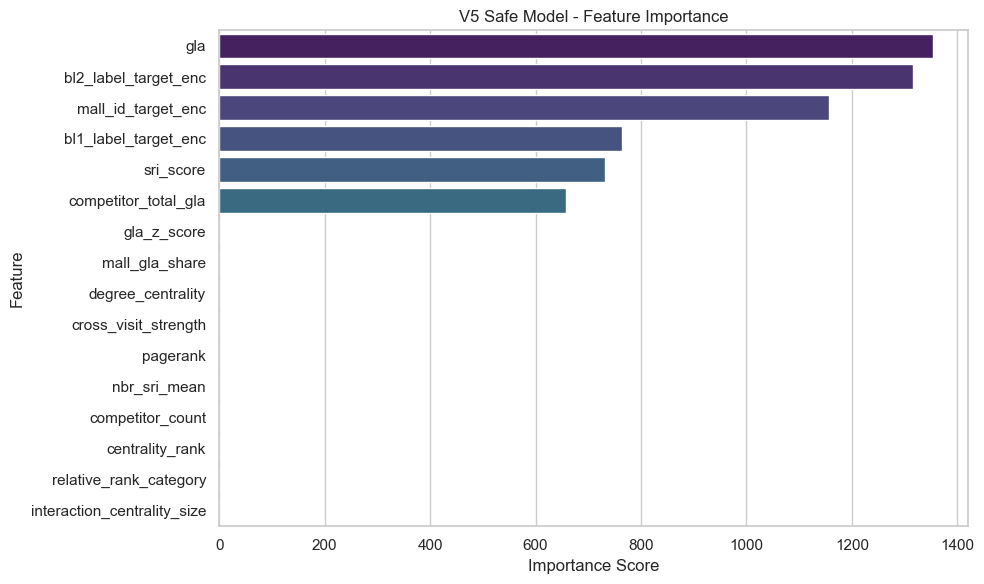

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Get feature importance from the trained model
importance = best_model.feature_importances_
feat_imp = pd.DataFrame({'Feature': X_final.columns, 'Importance': importance})
feat_imp = feat_imp.sort_values('Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp, x='Importance', y='Feature', palette='viridis')
plt.title('V5 Safe Model - Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

/var/folders/l7/6_r15vlj5839j1442vhdwjh80000gn/T/ipykernel_55912/1265382683.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  g = sns.barplot(data=feat_imp, x='Importance', y='Feature', palette='viridis')


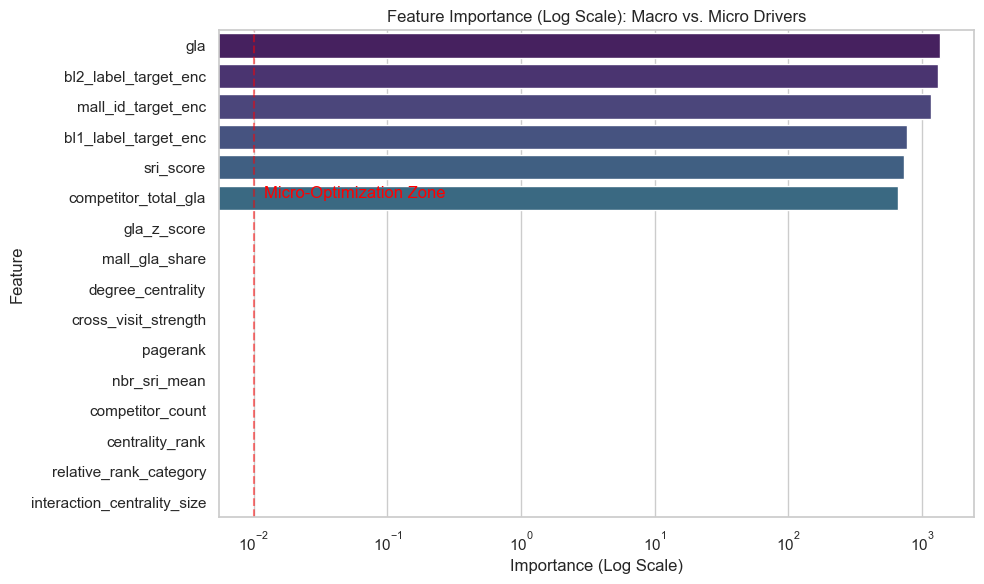

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get importance
importance = best_model.feature_importances_
feat_imp = pd.DataFrame({'Feature': X_final.columns, 'Importance': importance})
feat_imp = feat_imp.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
# LOG SCALE is the secret sauce here
g = sns.barplot(data=feat_imp, x='Importance', y='Feature', palette='viridis')
g.set_xscale("log") 

plt.title('Feature Importance (Log Scale): Macro vs. Micro Drivers')
plt.xlabel('Importance (Log Scale)')
plt.ylabel('Feature')
plt.axvline(x=0.01, color='red', linestyle='--', alpha=0.5) # Threshold line
plt.text(0.012, 5, "Micro-Optimization Zone", color='red')
plt.tight_layout()
plt.show()